### Objective 

Here, we perform a SARIMA model on 29 select zipcodes to subset the top five zipcodes that are evaluated to be most promising for real estate investment.


#### A description of the workflow that performs a SARIMA time series model on 29 selected zipcodes.


- Based on the prophet model evaluation of price forcast and calculated predicted annualized returns for every zipcode in a timeframe of 3 years (2018 until 2021), 29 zipcodes with a predicted annualized return of above 15% were selected for SARIMA forcast performed in this workflow.

- Modify the train dataset to only include the top 29 zipcodes.

- Find pdq and seasonal pdq parameters within a selected range that are associated with the best AIC value.

- Perform SARIMA model on one example zipcode in the train dataset to predict for up to 5 years in future using pdq and seasonal pdq parameters associated with the best AIC value.

- Perform SARIMA on all 29 zipcodes to predict for up to 5 years in future using pdq and seasonal pdq parameters associated with the best AIC value. 

- Calculate predicted annualized return values using train dataset from 2012-01 until 2018-06 and sort them based on a descending order. 

- Top zipcodes sorted by their predicted annualized return values are further explored based on a comparison of predicted vs real prices (test dataset) to narrow down to a selection of top 5.

In [1]:
#load necessary packages
import pandas as pd
import numpy as np
import pickle
import itertools
from datetime import datetime
import statsmodels.api as sm
import functions as fn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
#load and list the 29 zipcodes with top forcast returns of above 15% for years 2017-2021(based on prophet forcast) 
with open('pred_returns.pickle', 'rb') as f:
    top29zipcode_df = pickle.load(f)
    
zipcode_list = list(top29zipcode_df['RegionName'])

In [3]:
#load the data train dataset
with open('train.pickle', 'rb') as f:
    train_df = pickle.load(f)

In [4]:
train_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,2012-01-01,739600.0
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,2012-01-01,248800.0
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,2012-01-01,931300.0
3,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,2012-01-01,116000.0
4,93144,79936,El Paso,TX,El Paso,El Paso County,5,2012-01-01,112400.0


In [5]:
#get the list of zipcodes present in both train dataset and zipcodes with top forcast returns
unique = list((train_df['RegionName'].unique()))
topzipcodes = list(set(zipcode_list).intersection(unique))
topzipcodes

[94085,
 94086,
 94087,
 95112,
 95117,
 33805,
 30238,
 60064,
 48033,
 33830,
 33705,
 33069,
 33714,
 66102,
 92356,
 89030,
 32839,
 19146,
 95051,
 95050,
 95054,
 30032,
 30288,
 94041,
 94043,
 29405,
 30315,
 94063,
 32117]

In [6]:
# import retrieving_zipcode_info. See as an example the dataframe for zipcode 32905
top29zipcode_dicts= fn.retrieving_zipcode_info(train_df, topzipcodes)

# Perform SARIMA

1. Perform a SARIMA model for an example zipcode 32905 and generate output model plots. 
2. Perform a SARIMA model for all zipcodes.

## Perform an initial SARIMA model for an example zipcode 32905 and generate output model plots: 

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q.
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q.
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [8]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value for an example zipcode 94085. 
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(top29zipcode_dicts[94085],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]


#perform a SARIMA model on example zipcode 94085

SARIMA_MODEL = sm.tsa.statespace.SARIMAX(top29zipcode_dicts[94085],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = SARIMA_MODEL.fit()

print(output.summary().tables[1])

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/s

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2328.195765398084
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2947752.844083236
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1751.6326034027234
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =2508.782849152387
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1678.6134430690556
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1661.1773676112582
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1424.9107838182165


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1394.3054023394939
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =2246.4704143676645


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =2006.9864589021604
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1769.7080681931716


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =1253583.929201928
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1936.0160470389515


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =2006.5044206219322
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =1412.7763668924308


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =1361.4700741548927
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1704.8504378902655
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1440.9714004779908
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1419.059435971192
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =1166.1104798392241


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =1441.4262070892696
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =1425.8783565698964
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =1176.4970311152194


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =1162.8449778038375
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =1620.6879299779366


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1364.2156597277444
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1403.085781119155


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1104.9031534378635
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =1410.05964118572


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1366.2116981863003


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =1137.3339899589687


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1105.0271140693908
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1640.0286520573236
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1378.2665669441378


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1425.998053456543


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1172.8988213112088
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1389.068636041183
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1377.3020865807746
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1166.1578092261163


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1726.784987611899
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1553.7604598497032


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =1308.4982393071546
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1450.7769780737626


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =1725.6402239645452
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1333.6052864313274


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =1309.5723643257893


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =1127.6173860769838


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =1520.3187299125068
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1510.2566553684471
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1270.9586831433337
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1311.8591389794817
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =1063.202696625628
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =1269.262643501861
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =1271.11652203068


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =1054.8458395712762


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =1056.7579078750155
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =1483.0976456420253
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1231.3338051382855
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1289.909256062877


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1037.293791960857
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =1250.612412906758


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1232.5742007864803
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =1054.2014338667934


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1031.7689437195595


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8494      0.066     12.952      0.000       0.721       0.978
ma.L1          0.7231      0.093      7.739      0.000       0.540       0.906
ar.S.L12       0.2960      0.501      0.591      0.555      -0.686       1.278
ma.S.L12      -0.3132      0.525     -0.597      0.551      -1.341       0.715
sigma2      3.058e+07   1.36e-09   2.24e+16      0.000    3.06e+07    3.06e+07


/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


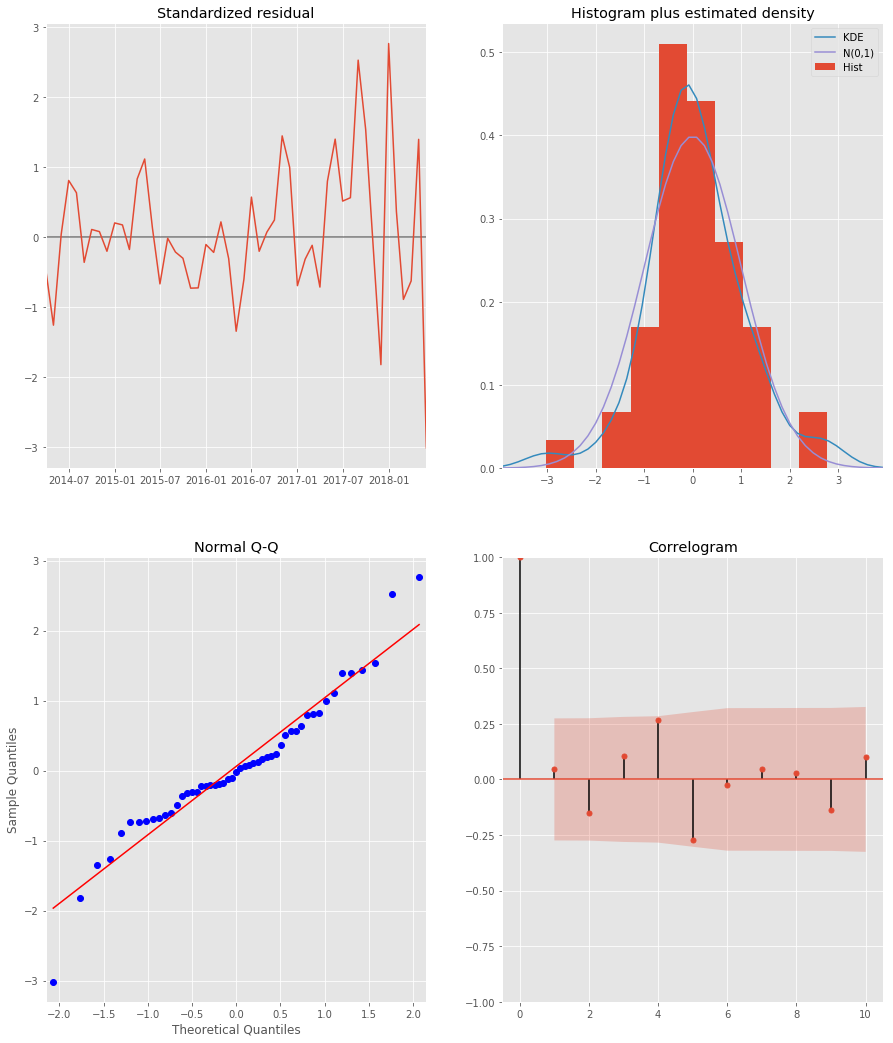

In [9]:
#plot output to evaluate 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [10]:
# Get forecast for 60 steps ahead in future for zipcode 94085
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts for zipcode 94085
pred_conf = prediction.conf_int()
pred_conf.tail()

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


,lower value,upper value
2023-02-01,753640.465660,5.692647e+06
2023-03-01,722181.385120,5.792982e+06
2023-04-01,678533.199263,5.880116e+06
2023-05-01,638402.917047,5.969505e+06
2023-06-01,590786.739531,6.049959e+06


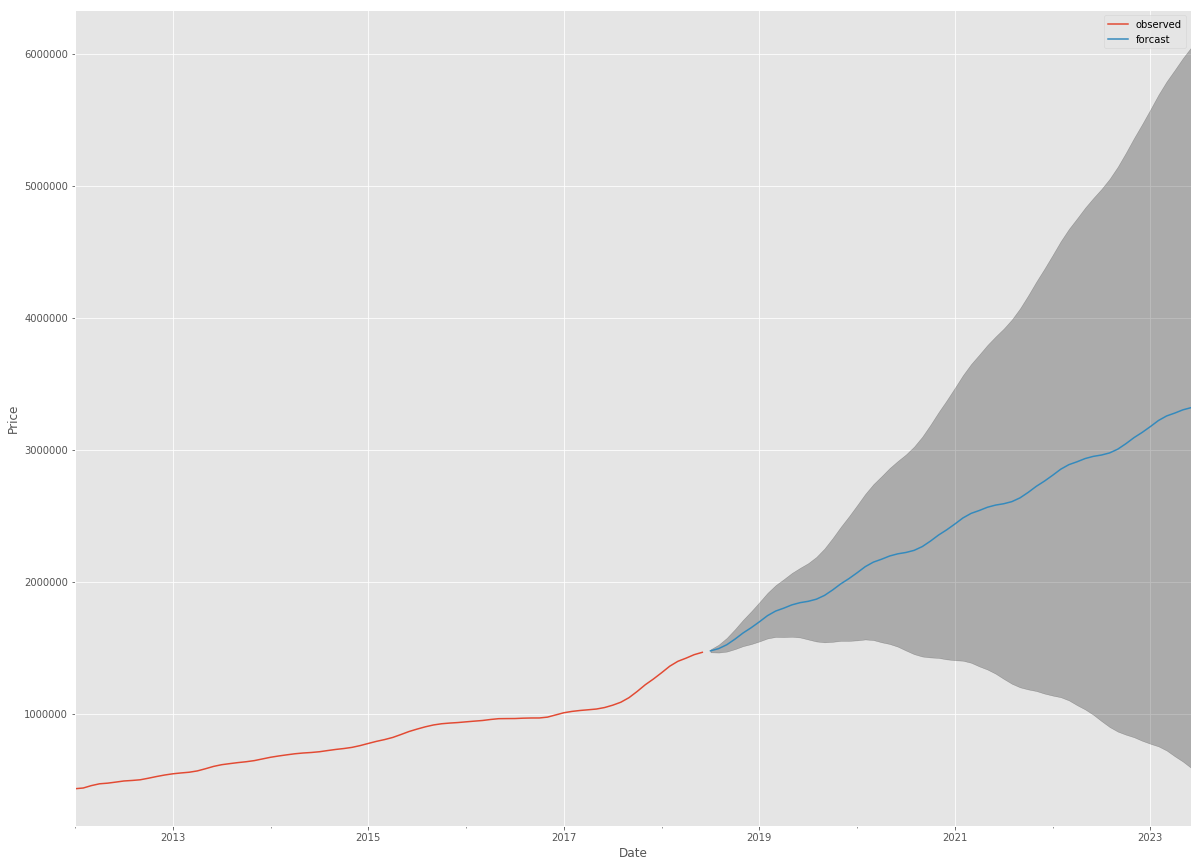

In [11]:
#The plot suggests the predicted mean of the median prices and 95% CIs for the example zipcode 94085. 

ax = top29zipcode_dicts[94085].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend(['observed', 'forcast'])
plt.show()

## Perform a SARIMA model for all zipcodes.

In [18]:
pred_29zipcodes={}
for zipcode in top29zipcode_dicts.keys():
    pred_29zipcodes[zipcode]= fn.model_SARIMA_zipcode(top29zipcode_dicts[zipcode],pdq,pdqs)

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/s

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

In [22]:
merged = pd.DataFrame(data=None)
for i in pred_29zipcodes.keys():
    df=pd.DataFrame()
    df['date']= pred_29zipcodes[i].conf_int().index
    df['RegionName'] = i
    df['pred_mean'] = np.array(pred_29zipcodes[i].predicted_mean)
    df['lower_value']=np.array(pred_29zipcodes[i].conf_int()['lower value'])
    df['upper_value']=np.array(pred_29zipcodes[i].conf_int()['upper value'])
    merged = pd.concat([merged, df], axis=0)

In [23]:
merged.tail()

,date,RegionName,pred_mean,lower_value,upper_value
55,2023-02-01,32117,198452.532127,11044.719217,385860.345037
56,2023-03-01,32117,200178.812153,7803.497894,392554.126411
57,2023-04-01,32117,200987.802674,3698.877759,398276.727589
58,2023-05-01,32117,201226.687753,-913.446054,403366.821561
59,2023-06-01,32117,200922.672681,-6000.622360,407845.967721


## Calculate annualized returns for SARIMA model forcasts from 2018 to 2023 for all 20 zipcodes.

I calculated the annualized returns for SARIMA model forcasts between years 2018 to 2023 for all 29 zipcodes.

In [24]:
#subset the merge dataframe to only get the data from 2018-07-01 to 2022-07-01
years = range(2018, 2023)
year_month_list = [datetime.strptime(f'{year}-07-01', '%Y-%m-%d').date() for year in years]
forecast_returns = merged.loc[merged['date'].isin(year_month_list)]
forecast_returns.head()

,date,RegionName,pred_mean,lower_value,upper_value
0,2018-07-01,94085,1.477419e+06,1.466581e+06,1.488257e+06
12,2019-07-01,94085,1.852824e+06,1.563704e+06,2.141944e+06
24,2020-07-01,94085,2.222924e+06,1.479959e+06,2.965890e+06
36,2021-07-01,94085,2.592226e+06,1.265123e+06,3.919328e+06
48,2022-07-01,94085,2.961400e+06,9.453893e+05,4.977410e+06


In [25]:
#subset the merge dataframe to only get the data from 2018 to 2023.
forecast_returns['returns'] = forecast_returns['pred_mean'].div(
    forecast_returns.groupby('RegionName')['pred_mean'].shift(1))

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
forecast_returns = forecast_returns.dropna(subset=['returns'])

Run the function annualised_returns below to get a dataframe consisting of predicted annualized returns for all zipcodes (29).  

In [37]:
forecast_returns = fn.annualised_returns(forecast_returns)

In [34]:
print(f"Sorted predicted annual returns: {forecast_returns['Ann_returns']}")

Sorted predicted annual returns: 27    0.220509
25    0.213978
26    0.206889
21    0.194591
20    0.194198
0     0.189867
22    0.183160
4     0.168352
19    0.159312
3     0.157061
2     0.155747
13    0.154313
15    0.153080
1     0.143079
18    0.141977
5     0.141429
8     0.136928
11    0.134203
23    0.131696
16    0.131173
12    0.122534
10    0.121680
9     0.121049
6     0.118693
14    0.116655
28    0.107760
17    0.102376
24    0.080390
7     0.003588
Name: Ann_returns, dtype: float64


In [39]:
with open('forecast_returns.pickle', 'wb') as f:
    pickle.dump(forecast_returns, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('pred_29zipcodes.pickle', 'wb') as f:
    pickle.dump(pred_29zipcodes, f, pickle.HIGHEST_PROTOCOL)